In [35]:
%load_ext autoreload
%autoreload 2
"""
    Some imports used throughout the notebook
"""
import time

from visualize import *

from cpmpy.transformations.normalize import toplevel_list
from factory import *
from read_data import get_data
from cpmpy.tools.explain import mus

import numpy as np
np.set_printoptions(linewidth=90)
# preload solvers
from cpmpy import SolverLookup
names = SolverLookup.solvernames()

import networkx as nx
import re
draw = lambda g,**kwargs : nx.draw_circular(g, width=5, node_size=500,**kwargs)

def pinpoint_to_constraints(G, model):
    #assert model.solve()
    draw_conflict(G, mus(m.constraints))

def graph_coloring(G, max_colors=None):
    n = G.number_of_nodes()
    if max_colors is None:
        max_colors = n
    
    m = cp.Model()
    # worst case: give each node a different color
    nodes = cp.intvar(1, max_colors, shape=n, name="Node")
    # constrain edges to have differently colored nodes
    m += [nodes[n1] != nodes[n2] for n1, n2 in G.edges()]
    m.minimize(cp.max(nodes))
    
    return m, nodes

def draw_conflict(graph, conflict, **kwargs):
    
    conflicting = []
    for cons in conflict:
        n1, n2 = cons.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        conflicting.append((a,b))
        
    colors = ["red" if (a,b) in conflicting else "black" for (a,b) in graph.edges()]       
    return draw(graph, edge_color=colors, **kwargs)

def get_avg_outputlits(seq):
    lits = sum(len(out.literals()) for _,_,out in seq[:-1])
    return lits / (len(seq)-1)

def get_avg_stepsize(seq):
    return sum(len(s) for _,s,_ in seq) / len(seq)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explanation techniques for CP
### Prof. Tias Guns, KU Leuven, Belgium
#### In collaboration with Ignace Bleukx, Emilio Gamba, Bart Bogaerts, Jo Devriendt, Dimos Tsouros

<p>&nbsp;</p>

<table><tr style="background: white;">
    <td>&nbsp;</td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/kul.jpg" width=40%></td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/erc.jpg" width=45%></td>
</tr></table>

<!-- Thanks to Bart Bogaerts, Emilio Gamba and Jo Devriendt -->


<small>This presentation is an executable Jupyter notebook</small>

Link to slides and more examples: https://github.com/CPMpy/XCP-explain

## AI and Constraint Solving

<center><img src="img/intro_ai.png" width="65%" align="center" style="margin-top:10px"></center>


## Constraint Solving

<img src="img/solutions_vizual.png" width="45%" align="right" style="margin-top:100px">

Solving combinatorial optimization problems in AI

- Vehicle Routing

- Scheduling

- Manufacturing

- Other combinatorial problems ...

## Model + Solve

<center><img src="img/model_solve.png" width=70%></center>

- Reason over the constraints to find a solution
- Find the optimal solution according to the objective 
    - (maximize gain or minimize penalty)

## What happens after Model + Solve?

<center><img src="img/model_solve.png" width=70%></center>

- What if no solution?
- What if user does not _like_ the solution?
- What if the user _expected_ a different solution?
- ...

Need for **explanations**

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<img src="img/interaction_figure4.png" width=30% align="right">

- **Deductive explanation:**
  - _What causes X?_
- **Counterfactual explanation**:
  - _What if I want Y instead of X?_

Can be combined in interactive systems:
   - _Iteratively refine explanation & model_

# Example XCP interaction

Toy example: graph coloring - color each node such that no adjacent nodes have the same color

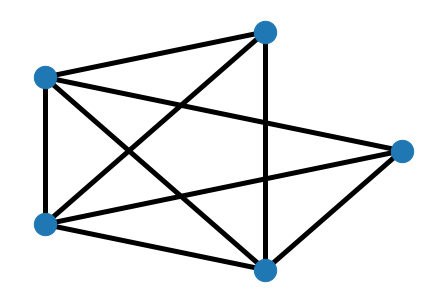

In [36]:
G = nx.fast_gnp_random_graph(5, 0.8, seed=0)
draw(G)

# Example XCP interaction

## Lets color this graph...

In [37]:
m, nodes = graph_coloring(G, max_colors=None)
assert m.solve() is True
print(m.status())
print(f"Found optimal coloring with {m.objective_value()} colors")

ExitStatus.OPTIMAL (0.0016836470000000001 seconds)
Found optimal coloring with 4 colors


<img src="img/why.png" width="15%" align="left" style="margin-top:-40px; margin-right:50px; margin-left: 300px">
yes... but why do we need 4? 

# Example XCP interaction

## _Why_ do we need at least 4 colors?

Pinpoint to constraints _causing_ this fact

# XXX -- why does this not work...

In [38]:
m, nodes = graph_coloring(G, max_colors=3) # less than 4?
print(m.solve())

draw_conflict(G, mus(m.constraints))

False


AssertionError: MUS: model must be UNSAT

# Explanation techniques in the wild

# XXX -- show visual sudoku the 3 images (to screenshot)

## CPMpy: http://cpmpy.readthedocs.io

We will use the CPMpy modeling library in Python for this presentation

<center><img src="img/cpmpy-intro.png" style="max-width: 70%;" /></center>

# TODO, update image with 'increment' somehwere, e.g. Direct, incremental solver access, also add Exact and z3, and add CHoco in to come

## Running example in this talk: Nurse Scheduling

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.

### hospital constraints:

<img src="img/nurse_rost_prob.jpg" align="right">

* nb of shifts required on each day
* max nb of shifts per nurse
* max nb of weekend shifts
* min/max consecutive shifts

### nurse constraints / preferences:

* specific days off-duty
* specific shift requests (on/off)

## Running example in this talk: Nurse Scheduling

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.

In [ ]:
instance = "Benchmarks/Instance1.txt"  # "http://www.schedulingbenchmarks.org/nrp/data/Instance1.txt"
data = get_data(instance)

## Nurse Rostering: data

Instances from http://www.schedulingbenchmarks.org/

"benchmark test instances from various sources including industrial collaborators and scientific publications."

<!-- 7 types of hospital constraints, 2 types of nurse constraints -->

In [42]:
#instance = "http://www.schedulingbenchmarks.org/nrp/data/Instance1.txt"
instance = "Benchmarks/Instance1.txt"
data = get_data(instance)

factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_full_model()  # CPMpy model with all constraints

model.solve() 
visualize(nurse_view.value(), factory)  # live decorated dataframe

In [ ]:
print("Nr of days to schedule:", data.horizon)
print("Nr of shift types:", len(data.shifts))

pd.merge(data.days_off, data.staff[["# ID","name"]], left_on="EmployeeID", right_on="# ID", how="left")

# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: unsatisfiable subsets
  - Minimal Unsatisfiable Subsets
  - MUSX naive algorithm
  - Efficient MUSes with incremental solvers
    - Assumption variables in clause learning solvers
    - Unsat core extraction
  - MUSX in practice (incremental + ordering of variables)
  - Many MUSes (enumeration with Marco)
  - Preferences over MUSes: QuickXplain algorithm
  - Optimal unsatisfiable subsets: OUS
    - hitting set algorithm
    - in practice (objective incrementality HS, subset incrementality SAT, ?complementary MCSs?)
* SAT: explaining logical consequences
  - computing (all) logical consequences:
      - unique solution
      - propagated assignment
      - maximal consequence algorithm
  - explaining one logical consequence
      - reformulation to MUS/OUS
  - step-wise explaining all logical consequences
      - OCUS
* OPT: explaining that no better solution exists
  - reformulation to MUS/OUS

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: Minimum Correction Subsets
  - graph coloring example
  - MCS / MSS relation
  - Optimisation over indicator variables
* UNSAT: corrective actions
  - Slack variables
  - Optimisation over slack variables
* SAT: checking a foil
  - concept of a 'foil'
  - add foil, recompute (explain UNSAT if needed)
* OPT: correcting the objective function
  - inverse optimisation
    

## Deductive Explanations in Constraint Solving

Explaing _why_ something follows from the constraints

We consider _why_ is there no solution?

Techniques presented are valid for explaining any deduced fact from the constraints

## Converting to Decision model


<img src="img/explain_unsat.png" width="15%" align="left" style="margin:50px;">

* Model nurse rostering problem as decision problem <br>
    (no objective)
        
* Nurse **preferences** are also hard constraints

In [ ]:
# model as decision model
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_decision_model()  # CPMpy DECISION Model
model.solve()

... no solution found

In [ ]:
constraints = toplevel_list(model.constraints, merge_and=False) # normalization for later
print(f"Model has {len(constraints)} constraints:")
for cons in constraints: print("-", cons)

## Minimal Unsatisfiable Subset (MUS)

<img src="img/mus.png" width="20%" align="left" style="margin:50px;">

Pinpoint to constraints causing a conflict

... trim model to minimal set of constraints

... minimize cognitive burden for user


### How to compute a MUS?

Deletion-based MUS algorithm

_[Joao Marques-Silva. Minimal Unsatisfiability: Models, Algorithms and Applications. ISMVL 2010. pp. 9-14]_

In [ ]:
def mus_naive(constraints):
    m = cp.Model(constraints)
    assert m.solve() is False, "Model should be UNSAT"
    
    core = constraints
    i = 0
    while i < len(core):
        subcore = core[:i] + core[i+1:]
        if cp.Model(subcore).solve() is True:
            i += 1 # removing makes it SAT, need to keep
        else:
            core = subcore # can safely delete 
    return core

### How to compute a MUS?

CPMpy implements an incremental version of this, using assumption variables

* `cpmpy.tools.mus`

In [ ]:
from cpmpy.tools.mus import mus, mus_naive

solver = "ortools"
subset = mus(model.constraints, solver=solver) 

print("Length of MUS:", len(subset))
for cons in subset: print("-", cons)

In [ ]:
visualize_constraints(subset, nurse_view, factory)

### Many MUS'es may exist...

_Liffiton, M.H., & Malik, A. (2013). Enumerating infeasibility: Finding multiple MUSes quickly. In
Proceedings of the 10th International Conference on Integration of AI and OR Techniques in Constraint
    Programming (CPAIOR 2013) (pp. 160–175)_

In [ ]:
# MARCO MUS/MSS enumeration
from explanations.marco_mcs_mus import do_marco
solver = "ortools"  # default solver
if "exact" in cp.SolverLookup.solvernames(): solver = "exact"  # fast for increment solving
    
t0 = time.time()
cnt = 0
for (kind, sset) in do_marco(model, solver=solver):
    if kind == "MUS":
        print("M", end="")
        cnt += 1
    else: print(".", end="") # MSS
    
    if time.time() - t0 > 15:  break  # for this presentation: break after 15s
print(f"\nFound {cnt} MUSes in", time.time() - t0)
 

### Many MUS'es may exist...

<img src="img/musses.png" width="40%" align="left" style="margin-left:50px; margin-right:50px">

This problem has just 168 constraints, yet 100.000+ MUSes exist...

Which one to show? 

In explanations less is more, so lets find the **smallest one directly!**

_Ignatiev, Alexey, et al. "Smallest MUS extraction with minimal hitting set dualization." International Conference on Principles and Practice of Constraint Programming. Cham: Springer International Publishing, 2015._

In [ ]:
from explanations.subset import smus

small_subset = smus(model.constraints, solver="ortools", hs_solver="gurobi")

print("Length of sMUS:", len(small_subset))
for cons in small_subset:  
    print("-", cons)

In [ ]:
visualize_constraints(small_subset, nurse_view, factory)

## Deductive explanations with MUS - conclusions

- MUS'es can poinpoint the user to a conflict, helps to understand

BUT

- There can be many MUSes, which one to show? Smallest? _Learn_ preferences?
- No guarantee the smallest MUS is understandable
    - Worst case, all constraints in conflict! (e.g., pigeon-hole problem)
- **MUSes do not show interaction between constraints**

## Step-wise explanation

<img src="img/explain_step-wise.png" width="20%" align="right" style="margin:50px;">

- Disect the conflict into smaller steps 
- Show _interaction_ between constraints <br>
  -> Step-wise Explanations

> Ignace Bleukx, Jo Devriendt, Emilio Gamba, Bart Bogaerts, Tias Guns. Simplifying Step-wise Explanation Sequences. 29th International Conference on Principles and Practice of Constraint Programming (CP23), 2023.

## Step-wise explanations

Find a sequence of small derivation steps, _explaining_ a goal set of literals (or a goal _fact_)

Each _step_ consists of a tuple $(\mathcal{E}, \mathcal{S}, \mathcal{N})$


Current work: explain how to solve logic puzzles **with a single solution** 

> Bogaerts, Bart, Emilio Gamba, and Tias Guns. "A framework for step-wise explaining how to solve constraint satisfaction problems." Artificial Intelligence 300 (2021): 103550.

<img src="img/stepwise.png" width="100%" align="center" style="">


In that setting _no_ risk on redundancy as **every** literal (cell in the sudoku) needs to be explained

Imagine only a subset of the cells needs to be explained.

How to decide which cells to derive during the sequence? Maybe "uninteresting cells" to the user are usefull as intermediate result?

Also applies to the UNSAT case, on which we will focus for now

## Step wise explaining unsatisfiability

**Challenges**

- How to find interpretable sequences? 
    - _I.e., with few and small steps?_
- How to deal with redundancy in the sequence? 
    - _I.e., how to decide what information is relevant to derive?_
- How to keep the algorithm interactive?
    - _I.e., how to find good sequences fast?_

## 3-phase approach:

Greedy construction of the sequence:
<img src="img/manysteps.png" width="80%" style="margin-bottom: -150px; margin-top: -50px"><br>
Removing redundant steps:
<img src="img/littledirtysteps.png" width="80%" style="margin-bottom: -100px;  margin-top:-50px;">
Clean each step from spurious input/output:
 <img src="img/littlecleansteps.png" width="45%" style="margin-top:-120px">

###  1. Greedy construction

<img src="img/greedy_construct.png" width="50%" align="left" style="margin:20px;">

**Maximal sequences**: 
- Use everyting available
- Derive everything possible



## Greedy construction for the Nurse rostering problem

In [ ]:
from explanations.stepwise import forward_construction
        
seq = forward_construction(model.constraints)
print(f"Found sequence of length {len(seq)}")
print("Avg nb of constraints used:", get_avg_stepsize(seq))

In [ ]:
nurse_view.clear()
for step in seq:
    display(visualize_step(step, nurse_view, factory))

\+ The good: <br>
- we get a sequence of explanation steps leading to the conflict!
- each step has low number of constraints

\- The bad: <br>
- the sequence is VERY long...

### 2. Filtering redundant steps

<img src="img/deletion_filter.png" width="40%" align="left" style="margin-right:40px;">
Try to remove step from sequence and check if sequence is valid

- If yes: remove the step,
- If no: we need the step in the sequence

Produces **maximal sequences**

In [ ]:
from explanations.stepwise import backward_filtering

filtered = backward_filtering(model.constraints, seq)
print(f"Filtered sequence to length {len(filtered)}")
print("Avg nb of output literals:", get_avg_outputlits(filtered))

In [ ]:
nurse_view.clear()
for step in filtered:
    display(visualize_step(step, nurse_view, factory))

\+ The good: <br>
- Our sequence is much shorter and easier to comprehend

\- The bad: <br>
- Individual steps may derive or use too much information

### 3. Simplify steps by removig input/output information

<img src="img/relaxation.png" width="50%" align="left" style="margin-right:40px;">

In [ ]:
from explanations.stepwise import relax_sequence

relaxed = relax_sequence(filtered, time_limit=100)
print(f"Relaxed sequence has length {len(relaxed)}")
print("Avg nb of output literals:", get_avg_outputlits(relaxed))

In [ ]:
nurse_view.clear()
for step in relaxed:
    display(visualize_step(step, nurse_view, factory))

## Results on benchmarks

<img src="img/steps.png" width="80%">

<img src="img/inputlits.png" width="80%">

<img src="img/outputlits.png" width="80%">

<img src="img/sudoku_runtime.pdf" width=44.5% style="float:left">
<img src="img/jobshop_runtime.pdf" width="40%" style="float:left;margin-top:25px">

# Conclusions

- Deductive explanations are a helpful means of explaining _why_ a problem is unsatisfiable

- Step-wise explanations can be applied to the problem of explaining unsatisfiability, BUT:
    - Need to take care for redundancy
- Open questions:
    - _Which_ sequence to show? _The_ shortest one? _Learn_ preferences?
    - How to improve runtime of the algorithm?
    - Tighter integration of forward-construction and backwards-filtering?
    
    




# Want to learn more?

<img src="img/qr-code.png" align="right" width="30%" style="margin-top:20px">

Tutorial with variety of explanation techniques recorded

Also includes _how_ to adapt the model to make it satisfiable 

(i.e., _contrastive_ explanations)

